<a href="https://colab.research.google.com/github/MuhammadBayuNugroho/analisis-sentimen-artikel/blob/main/Baru_of_02_Fiks_Pelabelan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PELABELAN DATASET**

### Oleh : Muhammad Bayu Nugroho
Untuk mendapatkan label sentimen positif, netral, dan negatif. Menggunakan teknik pelabelan berdasarkan kata kunci dan optimasi pelabelan menggunakan Random Classifier

# **1. Pelabelan Berbasis Keyword**

In [ ]:
# Import Library yang digunakan
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [ ]:
# Unduh NLTK stopwords jika belum diunduh
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Masukkan dataset hasil scrapping
file_path = '/content/drive/MyDrive/Dataset Analisis Sentimen/Baru 2 - Dataset_Komentar_Scrapping_All.csv'
dataset = pd.read_csv(file_path)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5562 entries, 0 to 5561
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Video ID      5562 non-null   object
 1   Author        5561 non-null   object
 2   Comment       5562 non-null   object
 3   Published At  5562 non-null   object
dtypes: object(4)
memory usage: 173.9+ KB


In [ ]:
# Hapus baris yang terdapat missing value / kosong
dataset.dropna(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5561 entries, 0 to 5561
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Video ID      5561 non-null   object
 1   Author        5561 non-null   object
 2   Comment       5561 non-null   object
 3   Published At  5561 non-null   object
dtypes: object(4)
memory usage: 217.2+ KB


In [ ]:
# Preprocessing Data
# 1. Ubah komentar menjadi lowercase
dataset['Comment'] = dataset['Comment'].str.lower()

# 2. Hapus spasi, karakter spesial, dan angka
dataset['Comment'] = dataset['Comment'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

In [ ]:
# 3. Menghapus stopwords menggunakan NLTK dan custom stopwords
nltk_stopwords = set(stopwords.words('indonesian'))  # NLTK stopwords untuk Bahasa Indonesia
custom_stopwords = {'yg', 'nya', 'nih', 'sih', 'tau', 'aja', 'deh'} # Example, replace with your actual custom words
all_stopwords = nltk_stopwords.union(custom_stopwords)

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in all_stopwords]
    return " ".join(filtered_words)

dataset['Comment'] = dataset['Comment'].apply(remove_stopwords)


In [ ]:
dataset.head(10)

,Video ID,Author,Comment,Published At
0,Dei1Pxq-y84,@hidayatdayat4227,pemerintah menaikan harga bbm krna subsidi bbm...,2022-12-18T14:49:19Z
1,Dei1Pxq-y84,@jokoyudilaksono8318,siapsiap beli motor listrik,2022-12-18T14:01:44Z
2,Dei1Pxq-y84,@trukgandeng5277,bermain kaya subsidi kaliam bilamg subsidi sal...,2022-12-18T13:21:02Z
3,R55pRFBDyAI,@nikitaCalista,baterai mahal mending beli,2024-11-04T12:45:25Z
4,R55pRFBDyAI,@netizenjulid9591,subsidi mobil listrik orng kaya guys klau emis...,2024-09-17T18:46:59Z
5,R55pRFBDyAI,@bernadiekoharyanto5479,emisi karbon dihasilkan produsennya abaikan,2024-06-02T01:50:46Z
6,R55pRFBDyAI,@radenmasaji2617,hhh orang kaya mah bebas ngga pake ganjil gena...,2024-03-25T12:29:33Z
7,R55pRFBDyAI,@romyalfallah,nikel kejam ev mncemari gk propagnda fitnah zi...,2024-03-16T03:21:50Z
8,R55pRFBDyAI,@mintopar4868,menghemat listrik mobil pakai panel sorya solo...,2023-10-10T11:36:00Z
9,R55pRFBDyAI,@Sarmen008-pw6sz,dinamo penggerak roda tahan genangan air g ya ...,2023-09-10T16:53:39Z


In [ ]:
# Daftar Kata Kunci Tiap Sentimen
keywords = {
    "positive": [
        "bagus", "hebat", "mantap", "sangat baik", "efisien", "terobosan", "inovasi","untung",
        "keren", "luar biasa", "brilian", "sukses", "bijak", "ramah lingkungan",
        "mengurangi emisi", "solusi polusi", "hijau", "lebih sehat", "peduli lingkungan",
        "bersih", "hemat energi", "terjangkau", "murah", "menguntungkan", "canggih",
        "teknologi maju", "modern", "berkualitas", "mudah digunakan", "nyaman", "praktis",
        "puas", "rekomendasi", "solusi masa depan", "cocok sekali", "keren abis", "sangar",
        "top markotop", "asik", "jos", "mantul", "gokil", "cuan banget", "inovasi keren",
        "kebijakan hebat", "bravo", "salut", "respect", "asri banget", "eco-friendly",
        "lestari", "ngurangin polusi", "high-tech", "modern banget", "super canggih",
        "oke banget", "worth it", "hemat", "murmer", "affordable", "auto nyaman",
        "user-friendly", "praktis banget", "gampang dipake", "upgrade cepat", "serius masuk pasar",
        "inovasi serius", "halus banget", "efisiensi tinggi", "masa depan cerah", "progres bagus",
        "disruption positif", "top banget"
    ],
    "negative": [
        "tidak efektif", "tidak berguna", "tidak masuk akal","sontoloyo", "membosankan", "gagal",
        "payah", "tidak bijak", "asal-asalan", "mahal", "terlalu mahal", "tidak terjangkau",
        "membebani rakyat", "harganya tinggi", "murahan tapi mahal", "rawan rusak", "aneh",
        "sulit diakses", "tidak efisien", "sulit diisi", "kurang praktis", "tidak stabil",
        "terbatas", "tidak yakin", "tidak percaya", "menipu", "hoax", "promosi saja",
        "tidak aman", "tidak ramah lingkungan", "malah polusi", "tidak nyaman", "bahaya",
        "bisa rusak lingkungan", "zonk", "parah banget","sampah", "nggak masuk akal", "kacau",
        "nggak bener", "lebay", "rip-off", "kecewa parah", "lemot", "seret", "bikin ribet",
        "ngelag", "susah banget", "nggak praktis", "bullshit", "hoax banget", "hoax", "ogah", "palsu",
        "bohong", "nggak percaya gw", "overpriced", "kemahalan", "nguras kantong",
        "nggak worth it", "bikin rugi", "malah repot", "nggak ada guna", "sampah banget",
        "subsidi habis", "harga naik", "tidak ada subsidi", "mencekik", "tolol", "baterai mahal",
        "sulit diisi", "charging ribet", "bekas sulit jual", "resiko kebakaran", "tidak efektif",
        "tidak masuk akal", "cuma buat pamer", "tidak layak tempur", "jelek"
    ],
    "neutral": [
        "apa ini", "bagaimana cara", "berapa biaya", "di mana tempat", "apakah tersedia",
        "harganya segini", "model baru", "tersedia di", "kapasitas baterai", "untung",
        "produksi dalam negeri", "subsidi pemerintah","mending", "jenis kendaraan", "menurut saya",
        "sepertinya", "mungkin bagus", "perlu diuji", "belum tahu", "butuh informasi lebih",
        "serius nih?", "benar nggak?", "gimana caranya?", "berapa lama?", "kapan ada?",
        "dimana tempatnya?", "harganya segini", "ini tuh produk", "spesifikasi apa",
        "model begini", "produksi lokal?", "menurut gw", "kayaknya", "bisa jadi",
        "tergantung sih", "mungkin aja", "lihat dulu", "berapa lama charging?",
        "bagaimana resale value?", "apakah garansi ada?", "suku cadang bagaimana?",
        "transisi ke EV", "kondisi pasar", "dampak ekonomi", "review produk", "benar tidak sih",
        "kalau bisa", "semoga"
    ]
}

In [ ]:
# Fungsi untuk memberi label komentar berdasarkan kata kunci
def label_comment(comment):
    if isinstance(comment, str):  # Memvalidasi apakah komentar berbentuk string
        comment_lower = comment.lower()  # Ubah komentar menjadi lowercase
        for label, words in keywords.items():
            if any(word in comment_lower for word in words):
                return label
    return "unknown"  # Berikan sentimen 'Unknown' jika tidak ada kata yang sesuai dengan kata kunci

# Terapkan fungsi pelabelan ke dataset
dataset['Sentiment'] = dataset['Comment'].apply(label_comment)  # Masukkan hasil sentimen ke kolom baru 'Sentiment'

In [ ]:
dataset.head()

,Video ID,Author,Comment,Published At,Sentiment
0,Dei1Pxq-y84,@hidayatdayat4227,pemerintah menaikan harga bbm krna subsidi bbm...,2022-12-18T14:49:19Z,unknown
1,Dei1Pxq-y84,@jokoyudilaksono8318,siapsiap beli motor listrik,2022-12-18T14:01:44Z,unknown
2,Dei1Pxq-y84,@trukgandeng5277,bermain kaya subsidi kaliam bilamg subsidi sal...,2022-12-18T13:21:02Z,unknown
3,R55pRFBDyAI,@nikitaCalista,baterai mahal mending beli,2024-11-04T12:45:25Z,negative
4,R55pRFBDyAI,@netizenjulid9591,subsidi mobil listrik orng kaya guys klau emis...,2024-09-17T18:46:59Z,neutral


In [ ]:
# Filter atau hapus baris dengan sentimen 'unknown'
dataset_filtered = dataset[dataset['Sentiment'] != "unknown"]

In [ ]:
# Tampilkan hasilnya
dataset_filtered.head(5)

,Video ID,Author,Comment,Published At,Sentiment
3,R55pRFBDyAI,@nikitaCalista,baterai mahal mending beli,2024-11-04T12:45:25Z,negative
4,R55pRFBDyAI,@netizenjulid9591,subsidi mobil listrik orng kaya guys klau emis...,2024-09-17T18:46:59Z,neutral
8,R55pRFBDyAI,@mintopar4868,menghemat listrik mobil pakai panel sorya solo...,2023-10-10T11:36:00Z,positive
12,R55pRFBDyAI,@biarbisa2629,mudahan ciptakan mesinnya terbatas listriknya,2023-06-21T06:00:23Z,negative
15,R55pRFBDyAI,@pokemonstuff3269,regulasi safetynya gak dibahas parkir garasi r...,2023-03-07T05:42:02Z,positive


In [ ]:
# Tampilkan distribusi sentimen yang didapat
distribution = dataset_filtered['Sentiment'].value_counts()
print("Sentiment Distribution:")
print(distribution)

Sentiment Distribution:
Sentiment
positive    1026
negative     490
neutral      211
Name: count, dtype: int64


In [ ]:
# Simpan hasil pelabelan dan filter dataset
dataset_filtered.to_csv('filtered_dataset.csv', index=False)

print("Dataset has been labeled and saved as 'filtered_dataset.csv' without 'unknown' sentiments.")


Dataset has been labeled and saved as 'filtered_dataset.csv' without 'unknown' sentiments.


Hasil pelabelan berdasarkan kata kunci adalah sebanyak 1727 baris komentar.
Dengan sentimen **positive** sebanyak 1026 komentar, sentimen **neutral** sebanyak 211 komentar, dan sentimen **negative** 490 komentar

# **2. Optimasi Pelabelan Menggunakan RandomForestClassifier**

In [ ]:
# Masukkan data hasil pelabelan berdasarkan kata kunci
file_path = '/content/filtered_dataset.csv'
data = pd.read_csv(file_path)

data.head()

# Memastikan bahwa kolom 'Comment' dan 'Sentiment' ada
print(data.columns)

# Pastikan bahwa tidak ada nilai kosong pada kolom 'Comment' dan 'Sentiment'
print(data.isnull().sum())

Index(['Video ID', 'Author', 'Comment', 'Published At', 'Sentiment'], dtype='object')
Video ID        0
Author          0
Comment         0
Published At    0
Sentiment       0
dtype: int64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Video ID      1727 non-null   object
 1   Author        1727 non-null   object
 2   Comment       1727 non-null   object
 3   Published At  1727 non-null   object
 4   Sentiment     1727 non-null   object
dtypes: object(5)
memory usage: 67.6+ KB


In [ ]:
# Pisahkan fitur (komentar) dan label (sentimen)
X = data['Comment']
y = data['Sentiment']

# Mengubah data teks menjadi fitur numerik menggunakan TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X)

# Menyeimbangkan dataset menggunakan SMOTE dengan k_neighbors yang lebih kecil
# k_neighbors di set ke minimum antara 5 dan jumlah sampel dalam kelas minoritas
k_neighbors = min(5, min(Counter(y).values()) - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Membagi dataset yang telah diseimbangkan menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [ ]:
# Tuning hyperparameter menggunakan GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],  # Menambah opsi untuk max_features
    'bootstrap': [True, False]  # Menambahkan opsi untuk bootstrap
}

# Membuat dan melatih classifier menggunakan GridSearchCV
classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menggunakan model terbaik dari hasil tuning
best_classifier = grid_search.best_estimator_

# Evaluasi model terbaik
y_pred = best_classifier.predict(X_test)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
336 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py"

In [ ]:
# Menghapus baris yang mengandung nilai NaN di seluruh dataset
data_cleaned = data.dropna()
data_cleaned.head(10)

,Video ID,Author,Comment,Published At,Sentiment
0,R55pRFBDyAI,@nikitaCalista,baterai mahal mending beli,2024-11-04T12:45:25Z,negative
1,R55pRFBDyAI,@netizenjulid9591,subsidi mobil listrik orng kaya guys klau emis...,2024-09-17T18:46:59Z,neutral
2,R55pRFBDyAI,@mintopar4868,menghemat listrik mobil pakai panel sorya solo...,2023-10-10T11:36:00Z,positive
3,R55pRFBDyAI,@biarbisa2629,mudahan ciptakan mesinnya terbatas listriknya,2023-06-21T06:00:23Z,negative
4,R55pRFBDyAI,@pokemonstuff3269,regulasi safetynya gak dibahas parkir garasi r...,2023-03-07T05:42:02Z,positive
5,R55pRFBDyAI,@anasarrow3708,dimengerti pemerintah menukar mosin dg molis h...,2023-02-25T14:24:57Z,positive
6,R55pRFBDyAI,@zulhamidi7388,susahnya perjalanan mobil listrik cocok ditera...,2022-12-29T19:56:18Z,positive
7,R55pRFBDyAI,@ayatostore5140,fikirin solusi dasar bahan bakarnya emg listri...,2022-12-07T15:02:14Z,negative
8,R55pRFBDyAI,@hamidi7284,mobil listerik mahal ketimbang mobil bbm jawab...,2022-12-05T09:19:30Z,negative
9,R55pRFBDyAI,@srihastuti8636,darimana mobil listrik ramah lingkungankalo mo...,2022-11-14T02:09:59Z,positive


Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.92      0.94      0.93       205
     neutral       0.98      0.99      0.98       205
    positive       0.92      0.90      0.91       206

    accuracy                           0.94       616
   macro avg       0.94      0.94      0.94       616
weighted avg       0.94      0.94      0.94       616

Confusion Matrix:
[[192   0  13]
 [  0 202   3]
 [ 16   5 185]]


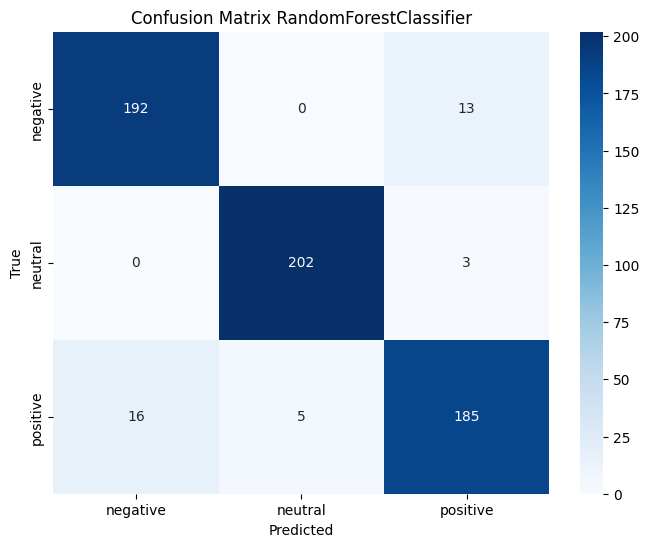

Akurasi model setelah optimasi: 0.94


In [ ]:
# Mengevaluasi model pada data uji
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_pred))  # Menampilkan metrik evaluasi seperti precision, recall, F1-score
print("Confusion Matrix:")
labels = np.unique(y_test)  # Pastikan untuk mendefinisikan labels secara eksplisit
cm = confusion_matrix(y_test, y_pred, labels=labels)
print(cm)

# visualisasikan hasilnya
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix RandomForestClassifier')
plt.show()

# Menghitung akurasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model setelah optimasi: {accuracy:.2f}")

In [ ]:
# Menyimpan model terbaik dan vectorizer untuk digunakan di masa mendatang
joblib.dump(best_classifier, 'optimized_sentiment_classifier.pkl')  # Menyimpan model terbaik
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')  # Menyimpan vectorizer untuk memproses data teks

print("Model dan vectorizer yang telah dioptimasi telah disimpan sebagai 'optimized_sentiment_classifier.pkl' dan 'tfidf_vectorizer.pkl'.")


Model dan vectorizer yang telah dioptimasi telah disimpan sebagai 'optimized_sentiment_classifier.pkl' dan 'tfidf_vectorizer.pkl'.


In [ ]:
# Melabeli ulang dataset dengan model otomatis yang dioptimasi
print("Melakukan pelabelan ulang pada seluruh dataset dengan model yang dioptimasi...")
X_full_tfidf = vectorizer.transform(data_cleaned['Comment'])
revised_labels = best_classifier.predict(X_full_tfidf)

Melakukan pelabelan ulang pada seluruh dataset dengan model yang dioptimasi...


In [ ]:
# Menyimpan hasil pelabelan ulang
data_cleaned['Revised_Sentiment'] = revised_labels
output_path = 'revised_labeled_dataset_optimized.csv'
data_cleaned.to_csv(output_path, index=False)

In [ ]:
data_cleaned.head(15)

,Video ID,Author,Comment,Published At,Sentiment,Revised_Sentiment
0,R55pRFBDyAI,@nikitaCalista,baterai mahal mending beli,2024-11-04T12:45:25Z,negative,negative
1,R55pRFBDyAI,@netizenjulid9591,subsidi mobil listrik orng kaya guys klau emis...,2024-09-17T18:46:59Z,neutral,neutral
2,R55pRFBDyAI,@mintopar4868,menghemat listrik mobil pakai panel sorya solo...,2023-10-10T11:36:00Z,positive,positive
3,R55pRFBDyAI,@biarbisa2629,mudahan ciptakan mesinnya terbatas listriknya,2023-06-21T06:00:23Z,negative,negative
4,R55pRFBDyAI,@pokemonstuff3269,regulasi safetynya gak dibahas parkir garasi r...,2023-03-07T05:42:02Z,positive,positive
5,R55pRFBDyAI,@anasarrow3708,dimengerti pemerintah menukar mosin dg molis h...,2023-02-25T14:24:57Z,positive,negative
6,R55pRFBDyAI,@zulhamidi7388,susahnya perjalanan mobil listrik cocok ditera...,2022-12-29T19:56:18Z,positive,positive
7,R55pRFBDyAI,@ayatostore5140,fikirin solusi dasar bahan bakarnya emg listri...,2022-12-07T15:02:14Z,negative,negative
8,R55pRFBDyAI,@hamidi7284,mobil listerik mahal ketimbang mobil bbm jawab...,2022-12-05T09:19:30Z,negative,negative
9,R55pRFBDyAI,@srihastuti8636,darimana mobil listrik ramah lingkungankalo mo...,2022-11-14T02:09:59Z,positive,positive


In [ ]:
# Menampilkan distribusi sentimen setelah pelabelan ulang
distribution = data_cleaned['Revised_Sentiment'].value_counts()
print("\nDistribusi sentimen setelah pelabelan ulang:")
print(distribution)


Distribusi sentimen setelah pelabelan ulang:
Revised_Sentiment
positive    1020
negative     493
neutral      214
Name: count, dtype: int64


Hasil optimasi pelabelan menggunakan RandomForestClassifier dan menggunakan Hyperparameter Tuning GridSearchCV, didapatkan distribusi sentimen akhir sebagai berikut:

1. Positive : 1020 komentar
2. Negative : 493 komentar
3. Neutral  : 214 komentar


Sehingga dataset ini nanti yang akan digunakan dalam proses preprocessing